In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

dff_nstds-thr-10.00


In [6]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'


# Output dir

In [7]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [8]:
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


#### Get metadata for stimulus

In [7]:
experiment = 'blobs'

In [8]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) \
                        for session, animalid, fovnum in sdata[['session', 'animalid', 'fovnum']].values]

sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [9]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [10]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
resp_filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [11]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy().reset_index(drop=True)
print('[%s] %i unique datakeys' % (experiment, len(stim_datakeys)))
curr_sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

[blobs] 25 unique datakeys


,animalid,session,fov
visual_area,,,
Li,9,9,9
Lm,8,8,8
V1,8,8,8


In [12]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, resp_filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_nstds-thr-10.00


In [13]:
curr_sdata.shape, sdata_exp.shape

((98, 7), (141, 7))

# Load gratings or blobs

In [14]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [15]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [16]:
# glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl' 
#                                                % (experiment, responsive_test, response_type)))

In [17]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[0]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

# Face tracker data

In [18]:
#### Set source/dst paths
dlc_home_dir = '/n/coxfs01/julianarhee/face-tracking'
dlc_project = 'facetracking-jyr-2020-01-25' #'sideface-jyr-2020-01-09'
dlc_project_dir = os.path.join(dlc_home_dir, dlc_project)

dlc_video_dir = os.path.join(dlc_home_dir, dlc_project, 'videos')
dlc_results_dir = os.path.join(dlc_project_dir, 'pose-analysis') # DLC analysis output dir

#### Training iteration info
dlc_projectid = 'facetrackingJan25'
scorer='DLC_resnet50'
iteration = 1
shuffle = 1
trainingsetindex=0
videotype='.mp4'
snapshot = 391800 #430200 #20900
DLCscorer = '%s_%sshuffle%i_%i' % (scorer, dlc_projectid, shuffle, snapshot)
print("Extracting results from scorer: %s" % DLCscorer)

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800


#### Check which datakeys are missing DLC -- ALL data

In [19]:
print("Checking for existing results: %s" % dlc_results_dir)
dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in sdata.index.tolist() 
                if '%s_%s' % (sdata.loc[i]['datakey'], sdata.loc[i]['experiment']) in dlc_analyzed_experiments]
dlc_dsets = sdata.iloc[ixs_wth_dlc]

dlc_datakeys = dlc_dsets['datakey'].unique()
sdata_datakeys = sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(sdata_datakeys)))


Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
35 of 66 datasets with DLC.


In [20]:
glob.glob(os.path.join(dlc_project_dir, 'dlc-models', 'iteration-%i' % iteration,\
                      '%s-trainset95shuffle%i' % (dlc_projectid, shuffle), 'train', 'snapshot-%i.meta' % snapshot))


['/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391800.meta']

#### Only include dsets with face-tracking

In [21]:
print("Checking for existing results: %s" % dlc_results_dir)
dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in curr_sdata.index.tolist() 
                if '%s_%s' % (curr_sdata.loc[i]['datakey'], curr_sdata.loc[i]['experiment']) in dlc_analyzed_experiments]
dsets = curr_sdata.iloc[ixs_wth_dlc]

dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = curr_sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys)))
missing_dlc = [i for i in exp_datakeys if i not in dlc_datakeys]
print("Need %i datasets analyzed:" % len(missing_dlc), missing_dlc)

Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
25 of 25 datasets with DLC.
('Need 0 datasets analyzed:', [])


#### Loading existing extracted pupil data

In [91]:
from pipeline.python.classifications import dlc_utils as dlcutils

In [22]:
bstate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state'
pupil_fpath = glob.glob(os.path.join(bstate_dir, '%s_pupil-traces_snapshot-%i.pkl' % (experiment, snapshot)))[0]
print(pupil_fpath)

# This is a dict, keys are datakeys
with open(pupil_fpath, 'rb') as f:
    PUPIL = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/blobs_pupil-traces_snapshot-391800.pkl


In [88]:
missing_dlc = [i for i in exp_datakeys if '%s_%s' % (i, experiment) not in PUPIL.keys()]
print("Missing %i datasets for DCL extraction:" % len(missing_dlc))
for i in missing_dlc: print('... %s' % i);

Missing 3 datasets for DCL extraction:
... 20190502_JC076_fov1
... 20190617_JC097_fov1
... 20190618_JC097_fov1


In [96]:
# Get trial alignment info
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC097'
session = '20190616'
fovnum = 1
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
# alignment_info
iti_pre_ms = float(alignment_info['iti_pre'])*1000
iti_post_ms = float(alignment_info['iti_post'])*1000
print("ITI pre/post: %.1f ms, %.1f ms" % (iti_pre_ms, iti_post_ms))

ITI pre/post: 1000.0 ms, 1000.0 ms


In [192]:
reload(dlcutils)

<module 'pipeline.python.classifications.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.py'>

In [193]:
face_feature = 'pupil'
for dkey in missing_dlc:
#     if dkey in PUPIL.keys():
#         continue
    if dkey=='20190502_JC076_fov1':
        continue
        
    print("[%s] getting extracted feature: %s" % (dkey, face_feature))
    session, animalid, fov = dkey.split('_')
    fovnum = int(fov[3:])
    fov = 'FOV%i_zoom2p0x' % fovnum

    #### Get labels
    labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                          '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
    l = np.load(labels_dfile)
    labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

    #### Load pupil data
    facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                                  feature=face_feature, epoch='trial_alignment', 
                                                  pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

    #### Parse pupil data into traces
    pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature='pupil')

    #### Add to dict
    datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
    PUPIL[datakey] = pupiltraces


[20190617_JC097_fov1] getting extracted feature: pupil
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '3', '4', '5', '6', '7'])
... finding movies for dset: 20190617_JC097_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f1_20190617171918189997')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f2_20190617184456598090')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f3_20190617193844438383')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f4_20190617203221873104')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f5_20190617212300056426')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f5b_20190617213156623714')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f6_20190617221519489496')
(7, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f6b_20190617222051144962')
(8, '/n/coxfs01/2p-data/eyetracker_tmp/20190617_JC097_fov1_blobs_f6c_20190617222

----- File 3.-----
... getting MW info for blobs run: 3 (run_3)
... 10 tifs in run (250 trials)
... Eyetracker dir: 20190618_JC097_fov1_blobs_f3_20190618132620604026
... checking for missing frames.
... found 10 funky frame chunks: [9, 19, 20, 4679, 7707, 7709, 11999, 14279, 16679, 17970]
... frame info shape changed from 21153 to 21213 frames
... Full run duration: 17.68 min
----- File 4.-----
... getting MW info for blobs run: 4 (run_4)
... 10 tifs in run (250 trials)
... Eyetracker dir: 20190618_JC097_fov1_blobs_f4_20190618142728681830
... checking for missing frames.
... found 5 funky frame chunks: [7379, 7381, 19379, 19381, 19383]
... frame info shape changed from 21625 to 21655 frames
... Full run duration: 18.05 min
----- File 5.-----
... getting MW info for blobs run: 5 (run_5)
... 10 tifs in run (250 trials)
... Eyetracker dir: 20190618_JC097_fov1_blobs_f5_20190618153819452731
... checking for missing frames.
... found 6 funky frame chunks: [2, 11, 3899, 3900, 4919, 11159]
...

In [118]:
import re

In [184]:
glob.glob(os.path.join('/n/coxfs01/2p-data/eyetracker_tmp', '20190502_JC076_fov1_blobs_f4_*', 'times', '*.txt'))

['/n/coxfs01/2p-data/eyetracker_tmp/20190502_JC076_fov1_blobs_f4_20190502182003125103/times/frame_times.txt']

# Load traces

In [261]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples

def resample_pupil_traces(pupiltraces, feature_name='pupil',  in_rate=20.0, out_rate=22.325, min_nframes=None):
    pupildfs = []
    if min_nframes is None:
        min_nframes = int(round(np.mean([len(g) for p, g in pupiltraces.groupby(['trial'])])))
    #print(min_nframes)
    for trial, g in pupiltraces.groupby(['trial']):
        if len(g[feature_name]) < min_nframes:
            npad = min_nframes - len(g[feature_name])
            vals = np.pad(g[feature_name].values, pad_width=((0, npad)), mode='edge')
        else:
            vals = g[feature_name].values[0:min_nframes]
        #print(len(vals))
        _, out_s = resample_traces(vals, in_rate=in_rate, out_rate=out_rate)
        currconfig = g['config'].unique()[0]
        pupildfs.append(pd.DataFrame({feature_name: out_s, 
                                       'config': [currconfig for _ in np.arange(0, len(out_s))],
                                       'trial': [trial for _ in np.arange(0, len(out_s))]} ))
    pupildfs = pd.concat(pupildfs, axis=0).reset_index(drop=True)
    return pupildfs


def zscore_array(v):
    return (v-v.mean())/v.std()

# Example FOV

In [25]:
include_stimuli='all'

animalid = 'JC097'
session = '20190616'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
print(sdf.shape)

Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
(50, 8)


In [26]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


In [27]:
# Get neural means
print(datakey)
neuraldf = MEANS[datakey].copy()
print(neuraldf.shape)

# Get pupil traces
pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
pupiltraces.head()


20190616_JC097_fov1
(1500, 297)


,config,pupil,trial
0,config004,33.363709,1
1,config004,33.359263,1
2,config004,33.837850,1
3,config004,34.106828,1
4,config004,29.055174,1


### (Example) Downsample and align traces

In [28]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))


Loading <dff> traces: test=nstds, thr=10.000


In [29]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))

#### Load traces of responsive cells
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels.groupby(['trial']))
roi_list = traces.columns.tolist()

Loading <dff> traces: test=nstds, thr=10.000
Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
296 of 432 cells responsive


In [31]:
# Temporal binning params
new_framerate = 20.0
framerate = 44.65

#n_frames_bin = np.ceil(framerate/new_framerate) #11.
#new_framerate = (framerate/n_frames_bin)
print("Downsampled fr: %.2f Hz" % new_framerate)


#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = stim_on/framerate

#### Get indices of trial epochs to model
pre_flank = round((iti_pre)*44.65) #n_on/2.
post_flank = round((iti_post)*44.65)  #n_on

# start_ix = int(stim_on-pre_flank)
# end_ix = int(stim_on + n_on + post_flank + 1)
# print(start_ix, end_ix, end_ix-start_ix)


Downsampled fr: 20.00 Hz


In [32]:
rid=90
# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]

#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
sample_data.shape

(1500, 135)

In [33]:
#### Get resampled indices of trial epochs
nframes_per_trial = sample_data.shape[1]
print("%i frames/trial" % nframes_per_trial)
out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), in_rate=framerate, out_rate=new_framerate)
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
print(new_stim_on)
new_n_on = int(round( stim_dur*new_framerate))
print(new_n_on)


135 frames/trial
20
20


In [34]:
#### Bin traces - Each tbin is a column, each row is a sample 
df = trialmat.fillna(method='pad').copy().T
xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
binned_trialmat = xdf.T
n_tbins = binned_trialmat.shape[1]
# binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
# n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list
#r_list.append(r_)

print(trialmat.shape, binned_trialmat.shape)


((1500, 135), (1500, 60))


### (Example) Test traces

In [35]:
included_trial_nums = sorted(pupiltraces['trial'].unique())

# Check with known config, known RID
ml=40 #-1
sz=20
#print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in included_trial_nums])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

[config022] plotting 30 of 30 trials


((1500, 135), (1500, 60))


<IPython.core.display.Javascript object>


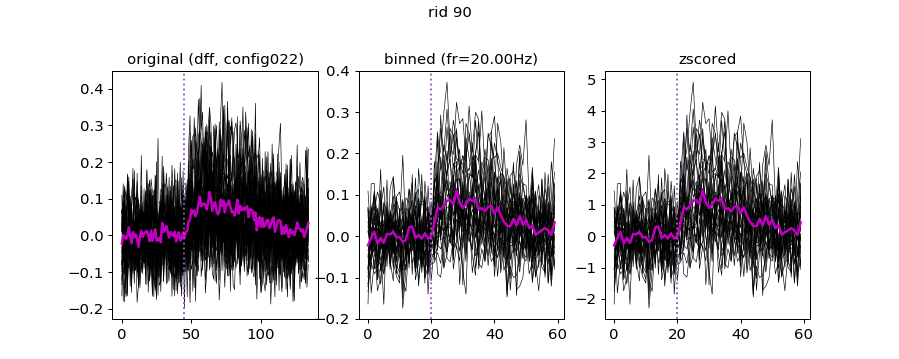

Text(0.5,0.98,u'rid 90')

In [36]:
print(trialmat.shape, binned_trialmat.shape)
#raw_ = trialmat.loc[included_trial_nums].copy()
#binned_ = binned_trialmat.loc[included_trial_nums].copy()
#zscored_ = zscored_neural.loc[included_trial_nums].copy()

fig, axn = pl.subplots(1, 3, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')

ax=axn[1]; ax.set_title('binned (fr=%.2fHz)' % (new_framerate));
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')


ax=axn[2]; ax.set_title('zscored');
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')
pl.subplots_adjust(top=0.8)
pl.suptitle('rid %i' % rid)


### (Example) Match pupil framerate

In [37]:
len(out_ixs)

60

In [38]:
print(new_framerate)
#### Resample pupil
desired_nframes = len(out_ixs) # 60
binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                     min_nframes=desired_nframes)


pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                              index=binned_trialmat.index, columns=binned_trialmat.columns)
print(pupil_trialmat.shape)


20.0
(1500, 60)


<IPython.core.display.Javascript object>


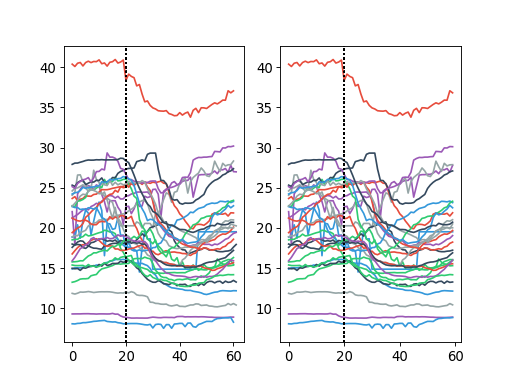

In [39]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in pupiltraces[pupiltraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    
ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')

<IPython.core.display.Javascript object>


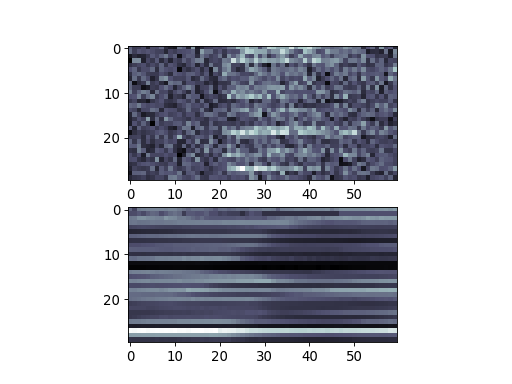

In [40]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')


### (Example) Get all rois and traces

In [47]:
pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
pupil_r['frame_int'] = [int(round(f)) for f in pupil_r['frame']]
interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
pupil_r['frame_ix'] = [interp_frame_ixs.index(f) for f in pupil_r['frame']]

print(pupil_r.shape)

In [42]:
r_list=[]
#rid=90
for rid in roi_list:
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]


    #### Bin traces - Each tbin is a column, each row is a sample 
    df = trialmat.fillna(method='pad').copy().T
    xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
    binned_trialmat = xdf.T # should be Ntrials # Nframes
    n_tbins = binned_trialmat.shape[1]

    #### Zscore traces 
    zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

    # Reshape roi traces
    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
    r_list.append(r_)

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]

# Combine all traces into 1 dataframe (all frames x nrois)
traces_r = pd.concat(r_list, axis=1)
print(r_.shape, traces_r.shape)
traces_r['config'] = cfg_list

_, dii = np.unique(traces_r.columns, return_index=True)
traces_r = traces_r.iloc[:, dii]
print(traces_r.shape)


((90000, 3), (90000, 888))
(90000, 299)


# Create data frames for pupil/neural data - test low/high pupil

In [49]:
# neuraldf = pd.concat([g[roi_list].mean(axis=0) for t, g in traces_r.groupby(['trial'])], axis=1).T
# print(neuraldf.shape)
# config_list = [g['config'].unique()[0] for t, g in traces_r.groupby(['trial'])]
print(datakey)
neuraldf=MEANS[datakey].copy()

20190616_JC097_fov1


In [50]:
pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
print(pupildf.shape)

pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

(1500, 5)


<IPython.core.display.Javascript object>


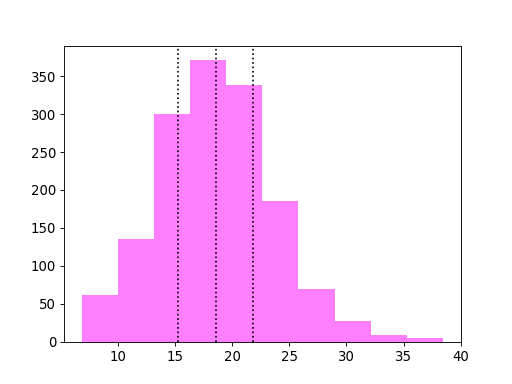

In [51]:
fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')

In [56]:
pupildf['quantile'] = pd.qcut(pupildf['pupil'], 3, labels=False)

In [57]:
pupildf.head()

,trial,frame,pupil,frame_int,frame_ix,quantile
0,1.0,67.0,26.252536,67.0,29.5,2
1,2.0,67.0,20.001838,67.0,29.5,1
2,3.0,67.0,26.760400,67.0,29.5,2
3,4.0,67.0,26.595349,67.0,29.5,2
4,5.0,67.0,21.042884,67.0,29.5,2


In [64]:
pupildf['quantile'].unique()
pupildf['quantile'].value_counts()

2    500
1    500
0    500
Name: quantile, dtype: int64

<IPython.core.display.Javascript object>


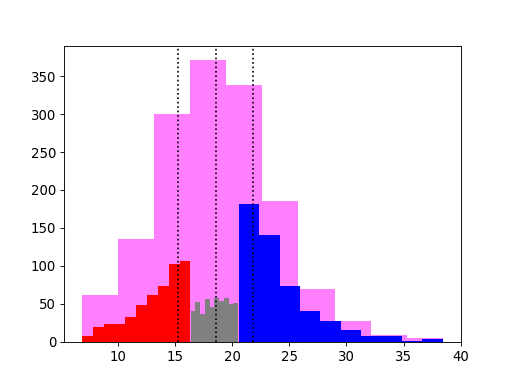

In [60]:
pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')
    
qcolors = ['r', 'gray', 'b']
for col, (i, pg) in zip(qcolors, pupildf.groupby(['quantile'])):
    ax.hist(pg['pupil'].values, color=col, )

## Subdivide pupil levels into high/low

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

import sklearn.metrics as skmetrics

In [66]:
import sklearn.metrics as skmetrics
import random

def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [67]:
def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):
    iter_results=[]
    iter_results_chance=[]
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        data = sample_data[curr_roi_list]
        zdata = (data - data.mean()) / data.std()

        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        train_data_chance=[]; test_data_chance=[]; 
        train_labels_chance=[]; test_labels_chance=[]; 
        train_data, test_data, train_labels, test_labels = train_test_split(zdata, targets['label'].values, 
                                                            test_size=0.2, stratify=targets['group'])

#         for sz in sizes: 
#             curr_configs = sdf[sdf['size']==sz].index.tolist()
#             curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
#             xi = zdata.loc[curr_trials]
#             yi = targets.loc[curr_trials]['label'].values

#             # Split train/test
#             train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2, startify=)
#             train_data.append(train_x)
#             test_data.append(test_x)
#             train_labels.append(train_y)
#             test_labels.append(test_y)
#         # Aggregate TRAIN/TEST data   
#         train_data = np.vstack(train_data)
#         train_labels = np.hstack(train_labels)
#         test_data = np.vstack(test_data)
#         test_labels = np.hstack(test_labels)

        #### DATA - Fit classifier
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())

        #### DATA - Test with held-out data
        test_data = scaler.transform(test_data)
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)

        #### DATA - Calculate MI
        predicted_labels = trained_svc.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict.update({'heldout_test_score': test_score, 
                         'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

        # ------------------------------------------------------------------
        # Shuffle LABELS to calculate chance level
        train_labels_chance = train_labels.copy()
        np.random.shuffle(train_labels_chance)
        test_labels_chance = test_labels.copy()
        np.random.shuffle(test_labels_chance)

        #### CHANCE - Fit classifier
        svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

        # CHANCE - Test with held-out data
        trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
        test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

        # Chance - Calculate MI
        predicted_labels = trained_svc_chance.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

    # DATA - get mean across iters
    df = pd.concat(iter_results, axis=0)
    df_chance = pd.concat(iter_results_chance, axis=0)
    
    return df, df_chance


In [69]:
low_pupil_thr = pupil_quantiles[0.25]
high_pupil_thr = pupil_quantiles[0.75]

#pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
#pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()
pupil_low = pupildf[pupildf['quantile']==0].copy()
pupil_high = pupildf[pupildf['quantile']==2].copy()

# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

print(pupil_low.shape, pupil_high.shape)


((500, 6), (500, 6))


In [70]:
m0=0
m100=106
C_value=1

n_iterations = 50

In [71]:
curr_data = neuraldf.copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)

# Fit LOW
curr_data = neuraldf.loc[low_trial_ixs].copy()
lo, lo_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)


# Fit HIGH
curr_data = neuraldf.loc[high_trial_ixs].copy()
hi, hi_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)


In [72]:
metric='heldout_test_score'
print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
print("low: %.2f (chance=%.2f)" % (lo.mean()[metric], lo_chance.mean()[metric]))
print("high: %.2f (chance=%.2f)" % (hi.mean()[metric], hi_chance.mean()[metric]))


all: 0.75 (chance=0.51)
low: 0.64 (chance=0.49)
high: 0.72 (chance=0.51)


# Set output dir for decoding w.r.t. behavior state

In [270]:
decoding_dir = os.path.join(aggregate_dir, 'behavior-state', 'decoding')
if not os.path.exists(decoding_dir):
    os.makedirs(decoding_dir)
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/decoding


# 1 visual area only

In [273]:
curr_dsets = dsets[dsets['visual_area']=='Li'].copy()

curr_dsets

,animalid,experiment,fov,session,visual_area,fovnum,datakey
3,JC076,blobs,FOV1_zoom2p0x,20190502,Li,1,20190502_JC076_fov1
39,JC090,blobs,FOV1_zoom2p0x,20190605,Li,1,20190605_JC090_fov1
44,JC091,blobs,FOV1_zoom2p0x,20190602,Li,1,20190602_JC091_fov1
48,JC091,blobs,FOV1_zoom2p0x,20190606,Li,1,20190606_JC091_fov1
75,JC099,blobs,FOV1_zoom2p0x,20190609,Li,1,20190609_JC099_fov1
79,JC099,blobs,FOV1_zoom2p0x,20190617,Li,1,20190617_JC099_fov1
88,JC113,blobs,FOV1_zoom2p0x,20191018,Li,1,20191018_JC113_fov1
92,JC117,blobs,FOV1_zoom2p0x,20191105,Li,1,20191105_JC117_fov1
96,JC120,blobs,FOV1_zoom2p0x,20191111,Li,1,20191111_JC120_fov1


In [277]:
reload(dlcutils)

<module 'pipeline.python.classifications.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/dlc_utils.py'>

In [278]:
# Calculate face feature
# ----------------------------------------------------------
face_feature = 'pupil_area'
#------------------------------------------------------------

for dkey in curr_dsets['datakey'].unique():
    if dkey=='20190502_JC076_fov1':
        continue
        
    print("[%s] getting extracted feature: %s" % (dkey, face_feature))
    session, animalid, fov = dkey.split('_')
    fovnum = int(fov[3:])
    fov = 'FOV%i_zoom2p0x' % fovnum

    #### Get labels
    labels_dfile = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*%s*' % experiment, 'traces',
                          '%s*' % traceid, 'data_arrays', 'labels.npz'))[0]
    l = np.load(labels_dfile)
    labels = pd.DataFrame(data=l['labels_data'], columns=l['labels_columns'])

    #### Load pupil data
    facemeta, pupildata = dlcutils.load_pose_data(animalid, session, fovnum, experiment, dlc_results_dir, 
                                                  feature_list=['pupil'], epoch='trial_alignment', 
                                                  pre_ITI_ms=iti_pre_ms, post_ITI_ms=iti_post_ms)

    #### Parse pupil data into traces
    pupiltraces = dlcutils.get_pose_traces(facemeta, pupildata, labels, feature=face_feature)

    #### Add to dict
    datakey ='%s_%s_fov%i_%s' % (session, animalid, fovnum, experiment)  
    PUPILTEST[datakey] = pupiltraces


[20190605_JC090_fov1] getting extracted feature: pupil_area
Loading pose data (dlc)
('[blobs] Found runs:', ['1', '2', '3', '4', '5', '6', '7'])
... finding movies for dset: 20190605_JC090_fov1_blobs
(0, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f1_20190605141933120131')
(1, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f2_20190605151304470267')
(2, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f3_20190605160757630689')
(3, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f4_20190605171707227152')
(4, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f5_20190605180717539830')
(5, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f6_20190605183331571376')
(6, '/n/coxfs01/2p-data/eyetracker_tmp/20190605_JC090_fov1_blobs_f7_20190605184821422690')
----- File 1.-----
... Eyetracker dir: 20190605_JC090_fov1_blobs_f1_20190605141933120131
... found 3 funky frame chunks: [428, 6719, 21359]
... Full run duration: 

... Eyetracker dir: 20190609_JC099_fov1_blobs_f1_20190609111435073145
... found 2 funky frame chunks: [8879, 12579]
... Full run duration: 14.10 min
----- File 2.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f2_20190609120626917118
... found 5 funky frame chunks: [3959, 10439, 13475, 15059, 15899]
... Full run duration: 15.08 min
----- File 3.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f3_20190609131907762511
... found 1 funky frame chunks: [8039]
... Full run duration: 17.09 min
----- File 4.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f4_20190609142912202443
... found 1 funky frame chunks: [3800]
... Full run duration: 14.60 min
----- File 5.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f5_20190609154127271261
... found 3 funky frame chunks: [7812, 10439, 14699]
... Full run duration: 13.96 min
----- File 6.-----
... Eyetracker dir: 20190609_JC099_fov1_blobs_f6_20190609155730800664
... found 3 funky frame chunks: [3059, 7499, 9024]
... Full run duration: 14

... Full run duration: 14.58 min
----- File 2.-----
... Eyetracker dir: 20191105_JC117_fov1_blobs_f2_20191105120405410749
... Full run duration: 15.80 min
----- File 3.-----
... Eyetracker dir: 20191105_JC117_fov1_blobs_f3_20191105132317902204
... Full run duration: 18.17 min
----- File 4.-----
... Eyetracker dir: 20191105_JC117_fov1_blobs_f4_20191105134239875931
... found 1 funky frame chunks: [11319]
... Full run duration: 15.22 min
----- File 5.-----
... Eyetracker dir: 20191105_JC117_fov1_blobs_f5_20191105143013757267
... found 1 funky frame chunks: [11741]
... Full run duration: 14.20 min
----- File 6.-----
... Eyetracker dir: 20191105_JC117_fov1_blobs_f6_20191105144537615692
... found 1 funky frame chunks: [17097]
... Full run duration: 15.54 min
... checking movies for dset: 20191105_JC117_fov1_blobs
... found 6 DLC outfiles, expecting 6 based on found eyetracker dirs.
...curr run: 1 [20191105_JC117_fov1_blobs_f1DLC_resnet50_facetrackingJan25shuffle1_391800.h5]
...curr run: 2 [2

In [ ]:
report_metric = 'heldout_test_score'
m0=0
m100=106
C_value=1
n_iterations = 100
skip = ['20190502_JC076_fov1'] # ['20190420_JC076_fov1']
use_quartiles = True
visual_area = 'V1'


curr_dsets = dsets[dsets['visual_area']==visual_area].copy()
d_list=[]; d_list_chance=[]; dkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 
n_datakeys = len(curr_dsets['datakey'].unique())

for di, (datakey, ds) in enumerate(curr_dsets.groupby(['datakey'])):
    if datakey in skip:
        continue
    
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    neuraldf = MEANS[datakey].copy() 
    print("----- %s -----" % datakey)
    
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPILTEST['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = resample_pupil_traces(pupiltraces, feature_name=face_feature,
                                         in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p[face_feature].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    if use_quartiles:
        pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
        low_pupil_thr = pupil_quantiles[0.25]
        high_pupil_thr = pupil_quantiles[0.75]
        pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
        pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()
    else:
        pupildf['quantile'] = pd.qcut(pupildf['pupil'], 3, labels=False)
        pupil_low = pupildf[pupildf['quantile']==0].copy()
        pupil_high = pupildf[pupildf['quantile']==2].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()[report_metric], df_chance.mean()[report_metric]))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()[report_metric], df_chance.mean()[report_metric]))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()[report_metric], df_chance.mean()[report_metric]))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)


1 of 8 datakeys
----- 20190420_JC076_fov1 -----
Creating blobs object [JC076|20190420|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
all: 0.58 (chance=0.49)
low: 0.56 (chance=0.50)
high: 0.61 (chance=0.50)
----- 20190507_JC083_fov1 -----
Creating blobs object [JC083|20190507|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
all: 0.83 (chance=0.50)
low: 0.86 (chance=0.50)
high: 0.71 (chance=0.53)
----- 20190522_JC084_fov1 -----
Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [281]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys



(12,)


<IPython.core.display.Javascript object>


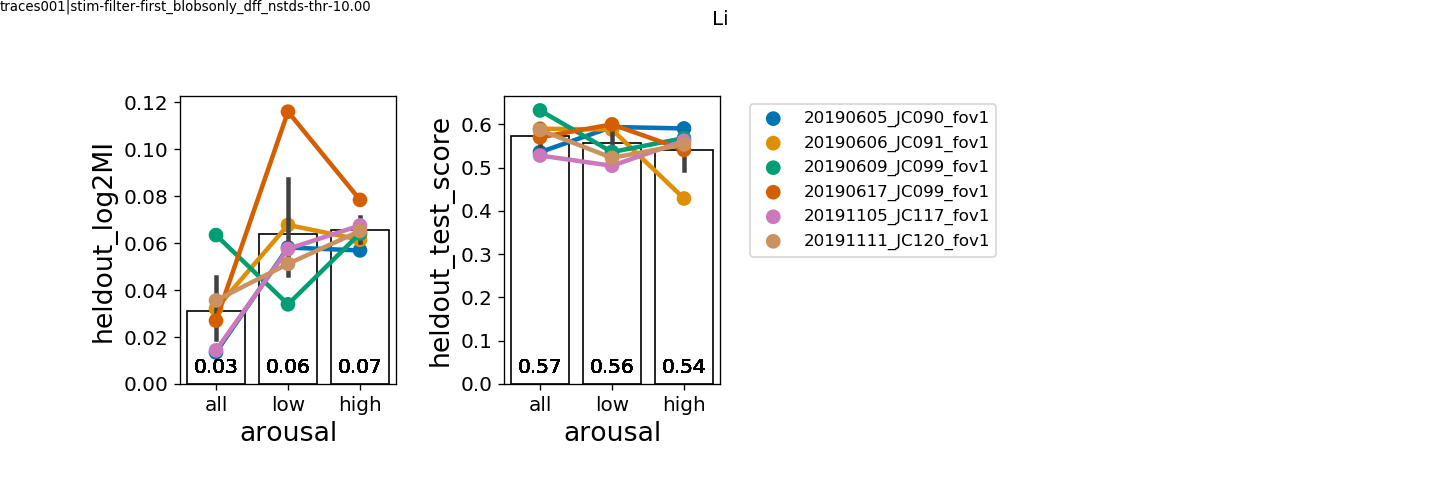

In [287]:
if visual_area == 'V1':
    skip = ['20190420_JC076_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1']
elif visual_area == 'Li':
    skip = ['20190602_JC091_fov1', '20191018_JC113_fov1']
else:
    skip = []
    
fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_log2MI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)
fig.suptitle(visual_area)

putils.label_figure(fig, data_id)

figname = 'split_%s_%s-test_classify_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


<IPython.core.display.Javascript object>


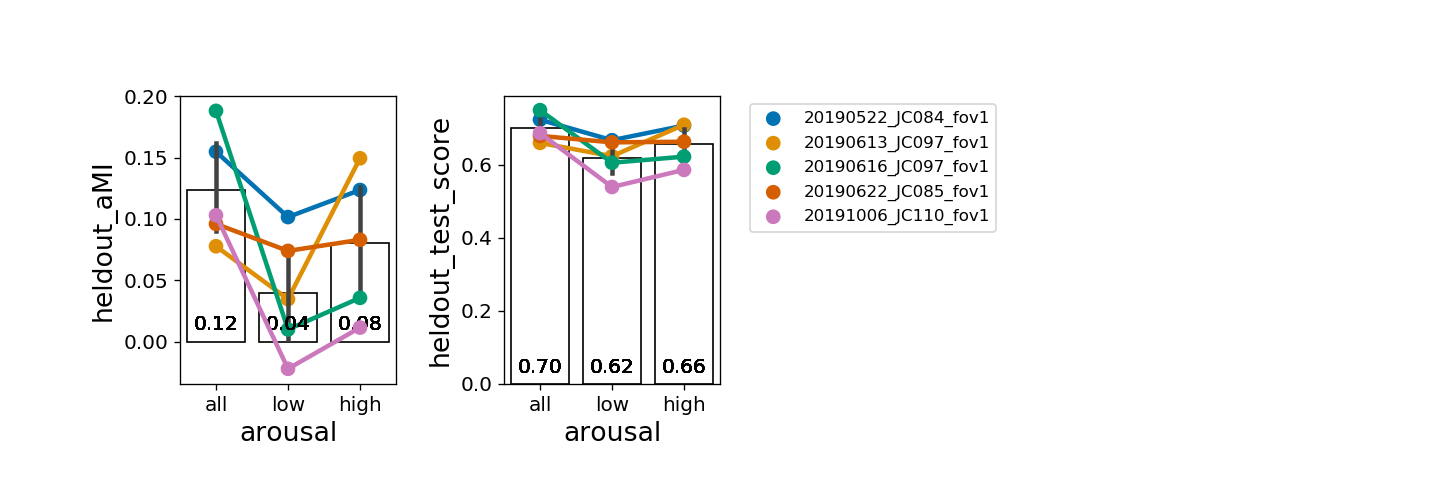

In [272]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)


figname = 'split_%s_%s-test_classify_%iv%i_C-%.2f, %i-iters' % (face_feature, visual_area, m0, m100, C_value, n_iterations)
pl.savefig(os.path.join(decoding_dir, '%s.svg' %figname))


<IPython.core.display.Javascript object>


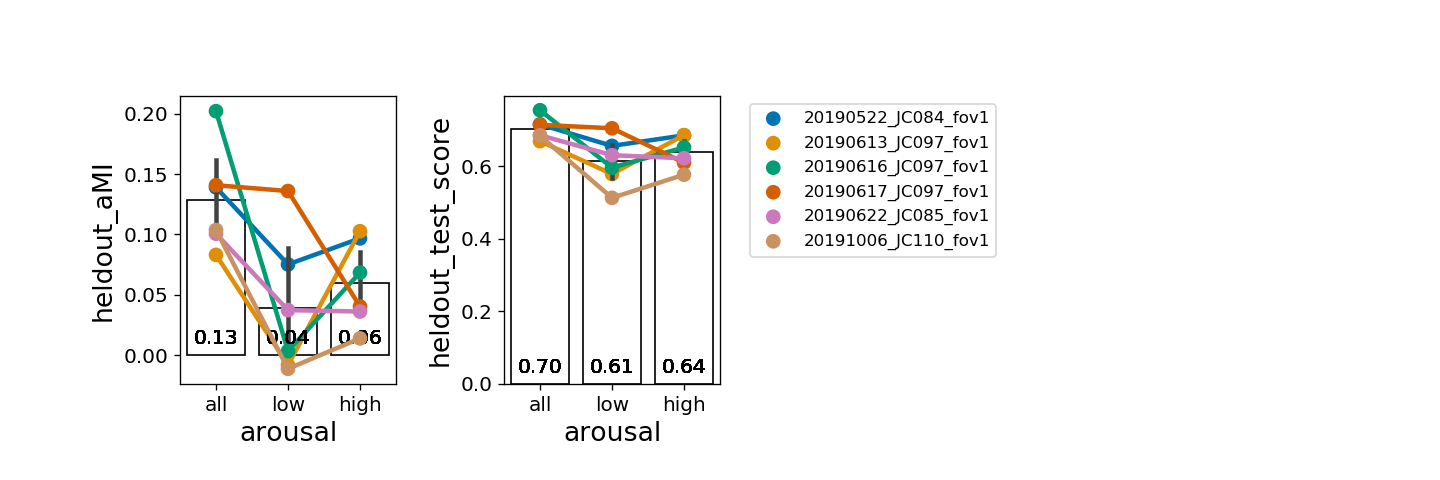

In [202]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


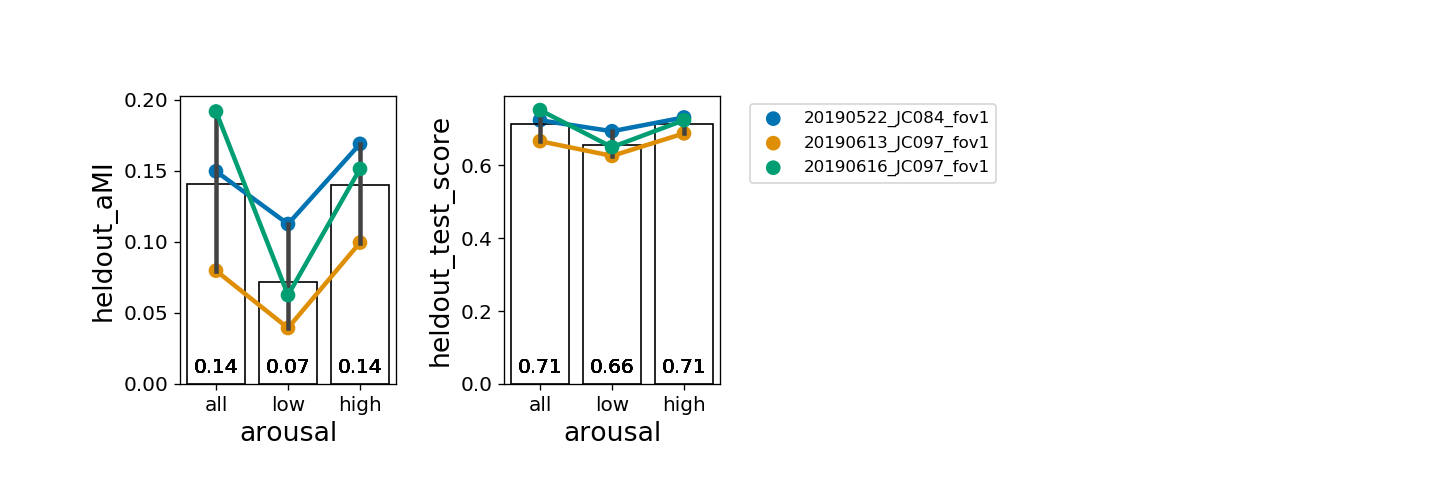

In [80]:
skip = ['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(12,4), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, ['heldout_aMI', 'heldout_test_score'])):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]
    
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    if ai==0:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5, wspace=0.5, hspace=0.2, top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>


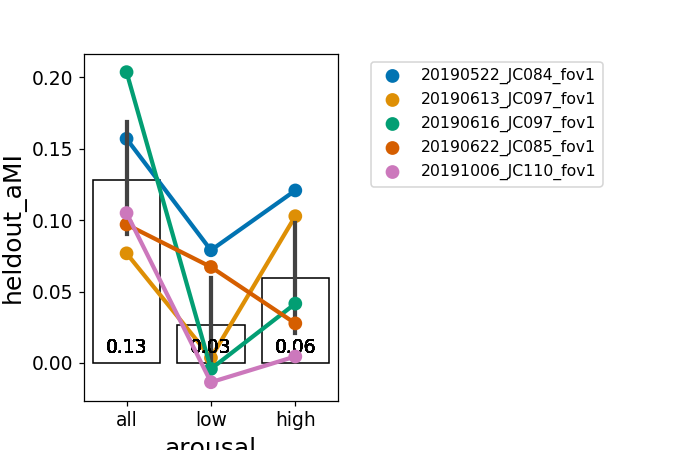

In [88]:
skip = [] #['20190420_JC076_fov1', '20190507_JC083_fov1']

fig, axn = pl.subplots(1, 2, figsize=(10,4), dpi=dpi)
for ax, metric in zpi(axn.flat, ['heldout_aMI', 'heldout_test_score']):

    # Create dataframe
    m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
    m_.columns = ['all', 'low', 'high']
    m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})
    m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
    m_df = m_df[~m_df['datakey'].isin(skip)]

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, 
                  palette='colorblind', s=10)
    sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    
ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


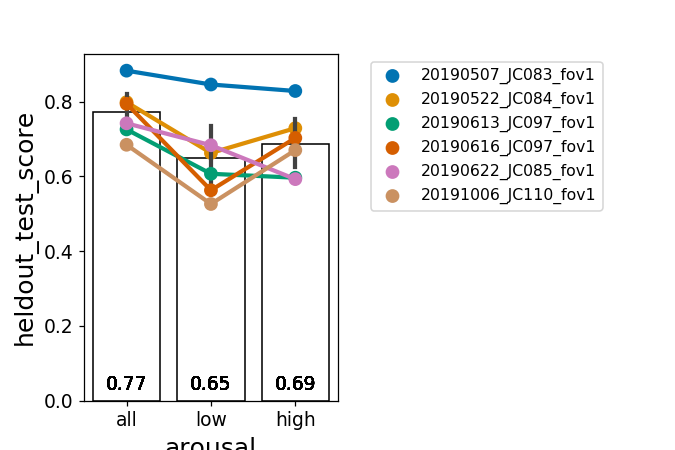

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


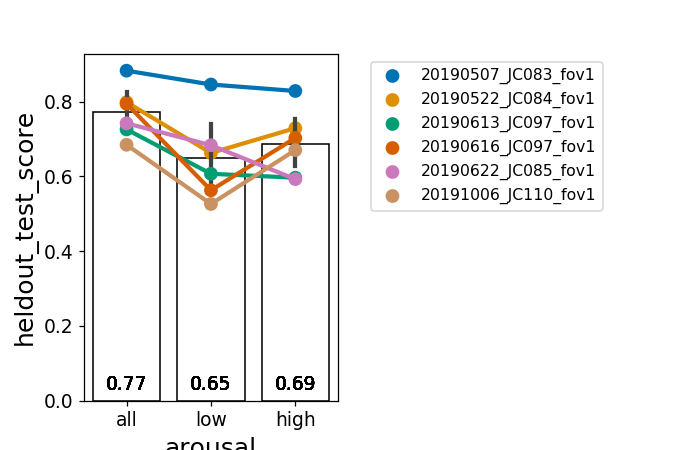

In [306]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


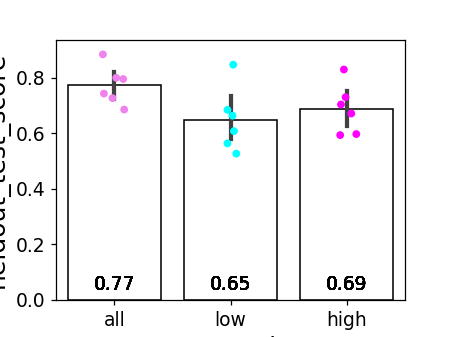

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
dtype: object

In [307]:
pupil_colors={'all': 'violet', 'low': 'aqua', 'high': 'magenta'}
fig, ax = pl.subplots(figsize=(4,3), dpi=dpi)
sns.stripplot(x='arousal', y=metric, data=m_df, ax=ax, palette=pupil_colors)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')


In [293]:
multi_comp_test='fdr_bh'
# Annotate w stats
print("********* [%s|%s] *********" % (experiment, metric))
#y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


********* [blobs|heldout_aMI] *********


KeyError: 'visual_area'

# Load RF data

In [204]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [205]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

matchblobs_reliable
N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


#### Get position info

In [206]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
print(aggr_rf_dir)
rf_filter_by=None

#df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s_%s.pkl' % (rf_filter_by, reliable_str, rfname))
df_fpath =  os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df= pkl.load(f)
        rfdf = df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
False


In [ ]:
if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rfdf[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)

        for ei, e_df in g.groupby(['experiment']):
            cell_ids = e_df['cell'].unique()
            p_ = fcoords['roi_positions'].loc[cell_ids]
            for p in pos_params:
                rfdf[p][e_df.index] = p_[p].values
    # with open(df_fpath, 'wb') as f:
    #     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [207]:
rfdf['datakey'].value_counts()

20190616_JC097_fov1    233
20190613_JC097_fov1    174
20190622_JC085_fov1    142
20190615_JC097_fov1    141
20191006_JC110_fov1    135
20190522_JC084_fov1    130
20190615_JC097_fov2    118
20190602_JC091_fov1    113
20190614_JC091_fov1     99
20190617_JC097_fov1     89
20191004_JC110_fov2     78
20190508_JC083_fov1     70
20190607_JC091_fov1     69
20191106_JC120_fov3     66
20190603_JC080_fov1     57
20190507_JC083_fov1     56
20190512_JC083_fov1     51
20191104_JC117_fov2     50
20190615_JC097_fov3     47
20191008_JC091_fov1     46
20190511_JC083_fov1     44
20190618_JC097_fov1     42
20190606_JC091_fov1     42
20190527_JC092_fov3     42
20190612_JC099_fov1     40
20191007_JC091_fov1     40
20191017_JC113_fov1     40
20190525_JC084_fov1     38
20190609_JC099_fov1     38
20190430_JC078_fov1     36
                      ... 
20190602_JC080_fov2     34
20190510_JC083_fov1     33
20191104_JC117_fov1     32
20190506_JC080_fov1     31
20190517_JC083_fov1     23
20191111_JC117_fov1     21
2

#### Select subset of RF data

In [208]:
r_list=[]
for datakey, expdf in dsets.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    #exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique())) 
    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    if len(rdf)==0:
        print("--- no RF! %s" % datakey)
        continue
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("(%s) Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


(20190602_JC091_fov1) Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
(20190613_JC097_fov1) Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
(20190616_JC097_fov1) Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
(20190618_JC097_fov1) Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
(20190622_JC085_fov1) Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
(20191006_JC110_fov1) Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


## Calculate overlap with stimulus (all RFs)

In [209]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

o_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):

    # Convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get stimulus info
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
    stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

    # Convert stimuli to polyon bounding boxes
    stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

stim_overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

Creating session object [JC076|20190502|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (-5, 8)
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating session object [JC090|20190605|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (15, 0)
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating session object [JC091|20190602|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|trac

Creating session object [JC097|20190617|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC097|20190617|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (25, 0)
Creating blobs object [JC097|20190617|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating session object [JC110|20191006|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (30, 0)
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static


In [210]:
d_list = []
for (visual_area, datakey), g in stim_overlaps.groupby(['visual_area', 'datakey']):
    if datakey not in MEANS.keys():
        print("No <%s> for RF key: %s" % (experiment, datakey))
        continue
        
    # Get EXPERIMENT responsive cells
    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    
    # Get RF fit cells
    rf_rids = sorted(g['cell'].unique())
    
    # Get cells in common
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, %i cells" % (visual_area, datakey, len(common_rids)))
    
    d_list.append(g[g['cell'].isin(common_rids)].copy())
    
has_blobs = pd.concat(d_list, axis=0)
print(has_blobs.shape)

[Li] 20190502_JC076_fov1, 15 cells
[Li] 20190602_JC091_fov1, 59 cells
[Li] 20190605_JC090_fov1, 9 cells
[Li] 20190606_JC091_fov1, 26 cells
[Li] 20190609_JC099_fov1, 22 cells
[Li] 20190617_JC099_fov1, 4 cells
[Li] 20191018_JC113_fov1, 6 cells
[Li] 20191105_JC117_fov1, 0 cells
[Li] 20191111_JC120_fov1, 1 cells
[Lm] 20190430_JC078_fov1, 31 cells
[Lm] 20190504_JC078_fov1, 10 cells
[Lm] 20190506_JC080_fov1, 30 cells
[Lm] 20190508_JC083_fov1, 61 cells
[Lm] 20190512_JC083_fov1, 39 cells
[Lm] 20190525_JC084_fov1, 36 cells
[Lm] 20190618_JC097_fov1, 24 cells
[Lm] 20190627_JC091_fov1, 6 cells
[V1] 20190420_JC076_fov1, 30 cells
[V1] 20190507_JC083_fov1, 55 cells
[V1] 20190522_JC084_fov1, 107 cells
[V1] 20190613_JC097_fov1, 88 cells
[V1] 20190616_JC097_fov1, 119 cells
[V1] 20190617_JC097_fov1, 84 cells
[V1] 20190622_JC085_fov1, 97 cells
[V1] 20191006_JC110_fov1, 72 cells
(5155, 9)


In [211]:
overlap_thr = 0.8
has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,127,127
Lm,201,201
V1,650,650


In [212]:
curr_min_pass = has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell'].min()
print("Min N pass: %i (overlap thr=%.2f)" % (curr_min_pass, overlap_thr))

Min N pass: 127 (overlap thr=0.80)


In [216]:
# SDF={}
# for datakey, g in globaldf.groupby(['datakey']):
#     session, animalid, fov_ = datakey.split('_')
#     fovnum = int(fov_[3:])
#     obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
#     sdf = obj.get_stimuli()
#     SDF[datakey] = sdf

In [214]:
overlap_thr=0.8
n_iterations=50
NCELLS =  60
min_ncells=10

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
# globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 



-------- Overlap: 0.80 --------


In [217]:
# for k, d in SDF.items():
#     if len(np.where(sdf['morphlevel']!=d['morphlevel'])[0]) > 0:
#         print(k)
#     if len(np.where(sdf['size']!=d['size'])[0]) > 0:
#         print(k)

In [224]:
overlap_thr=0.8
pass_dsets = has_blobs[(has_blobs['perc_overlap']>=overlap_thr)].copy()

cell_counts = pass_dsets[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
cell_counts = cell_counts.rename(columns={'cell': 'n_cells'})
cell_counts

cell
visual_area datakey                  
Li          20190502_JC076_fov1    14
            20190602_JC091_fov1    57
            20190605_JC090_fov1     8
            20190606_JC091_fov1    21
            20190609_JC099_fov1    20
            20190617_JC099_fov1     1
            20191018_JC113_fov1     5
            20191111_JC120_fov1     1
Lm          20190430_JC078_fov1    24
            20190504_JC078_fov1     8
            20190506_JC080_fov1    27
            20190508_JC083_fov1    52
            20190512_JC083_fov1    33
            20190525_JC084_fov1    30
            20190618_JC097_fov1    22
            20190627_JC091_fov1     5
V1          20190420_JC076_fov1    30
            20190507_JC083_fov1    55
            20190522_JC084_fov1   107
            20190613_JC097_fov1    87
            20190616_JC097_fov1   118
            20190617_JC097_fov1    84
            20190622_JC085_fov1    97
            20191006_JC110_fov1    72

In [235]:
min_ncells =20
too_few_cells = cell_counts[cell_counts['n_cells'] < min_ncells]['datakey'].unique()
print("%i datasets, too few (min=%i cells)" % (len(too_few_cells), min_ncells))
print too_few_cells



7 datasets, too few (min=20 cells)
['20190502_JC076_fov1' '20190605_JC090_fov1' '20190617_JC099_fov1'
 '20191018_JC113_fov1' '20191111_JC120_fov1' '20190504_JC078_fov1'
 '20190627_JC091_fov1']


In [237]:
metric = 'heldout_test_score'

d_list=[]; d_list_chance=[]; dkeys=[]; vkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 

n_datakeys = len(pass_dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(pass_dsets.groupby(['visual_area', 'datakey'])):
    if datakey in too_few_cells:
        print("(%s) Too few pass: %i"% (datakey, len(ds['cell'].unique())))
        continue

    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
    
    # ------ Neural ----------------------------------------------
    # Only select cells that pass conditions
    print("**** [%s] %s *****" % (visual_area, datakey))
    config_list = MEANS[datakey]['config']
    roi_list = ds['cell'].unique()
    ncells_t = MEANS[datakey].shape[1]-1
    neuraldf = MEANS[datakey][roi_list].copy() 
    neuraldf['config'] = config_list
    # sdf = SDF[datakey].copy()
    print("... (%s | %s) %i of %i cells" % (visual_area, datakey, len(roi_list), ncells_t))    
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)
    vkeys.append(visual_area)

(20190502_JC076_fov1) Too few pass: 14
**** [Li] 20190602_JC091_fov1 *****
... (Li | 20190602_JC091_fov1) 57 of 241 cells
all: 0.76 (chance=0.49)
low: 0.72 (chance=0.51)
high: 0.75 (chance=0.51)
(20190605_JC090_fov1) Too few pass: 8
**** [Li] 20190606_JC091_fov1 *****
... (Li | 20190606_JC091_fov1) 21 of 136 cells
all: 0.58 (chance=0.49)
low: 0.44 (chance=0.56)
high: 0.44 (chance=0.51)
**** [Li] 20190609_JC099_fov1 *****
... (Li | 20190609_JC099_fov1) 20 of 78 cells
all: 0.61 (chance=0.51)
low: 0.49 (chance=0.52)
high: 0.48 (chance=0.48)
(20190617_JC099_fov1) Too few pass: 1
(20191018_JC113_fov1) Too few pass: 5
(20191111_JC120_fov1) Too few pass: 1
**** [Lm] 20190430_JC078_fov1 *****
... (Lm | 20190430_JC078_fov1) 24 of 187 cells
all: 0.59 (chance=0.49)
low: 0.55 (chance=0.51)
high: 0.53 (chance=0.46)
(20190504_JC078_fov1) Too few pass: 8
11 of 24 datakeys
**** [Lm] 20190506_JC080_fov1 *****
... (Lm | 20190506_JC080_fov1) 27 of 226 cells
all: 0.67 (chance=0.51)
low: 0.70 (chance=0.51)

In [238]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys
full_df['visual_area'] = vkeys
full_chance['visual_area'] = vkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys
lo_df['visual_area'] = vkeys
lo_chance['visual_area'] = vkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys
hi_df['visual_area'] = vkeys
hi_chance['visual_area'] = vkeys


(12,)


<IPython.core.display.Javascript object>


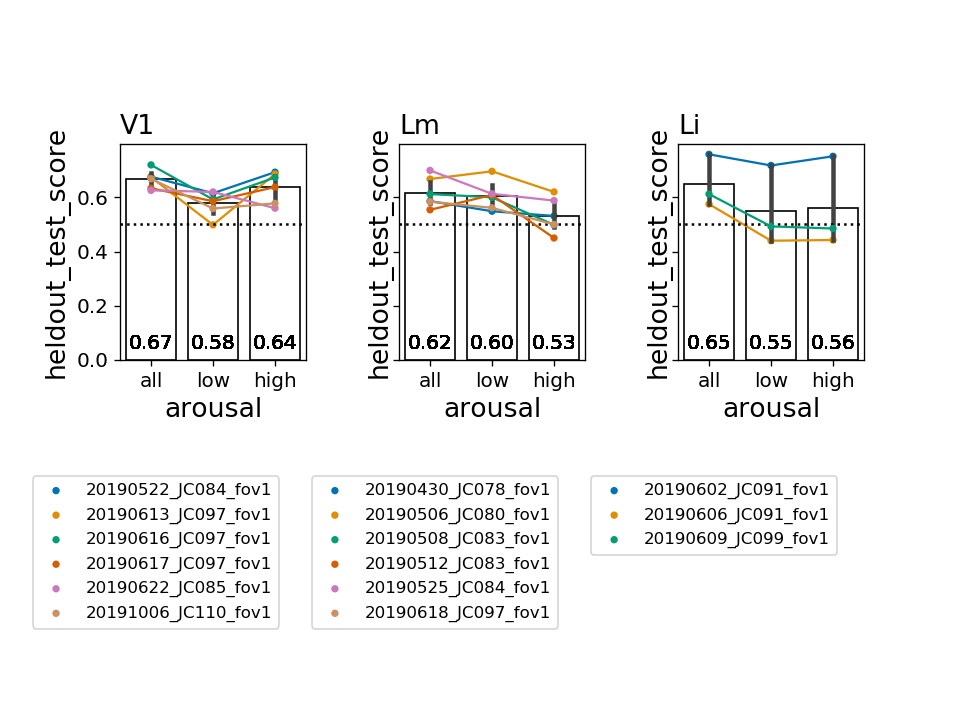

In [254]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
skip = ['20190507_JC083_fov1', '20190420_JC076_fov1']

metric='heldout_test_score'
#metric='heldout_aMI'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(skip)]

# plot
ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,6), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True, scale=0.5)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')

    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.axhline(y=0.5, color='k', linestyle=':')
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
    
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
#sns.despine(trim=True)

<IPython.core.display.Javascript object>


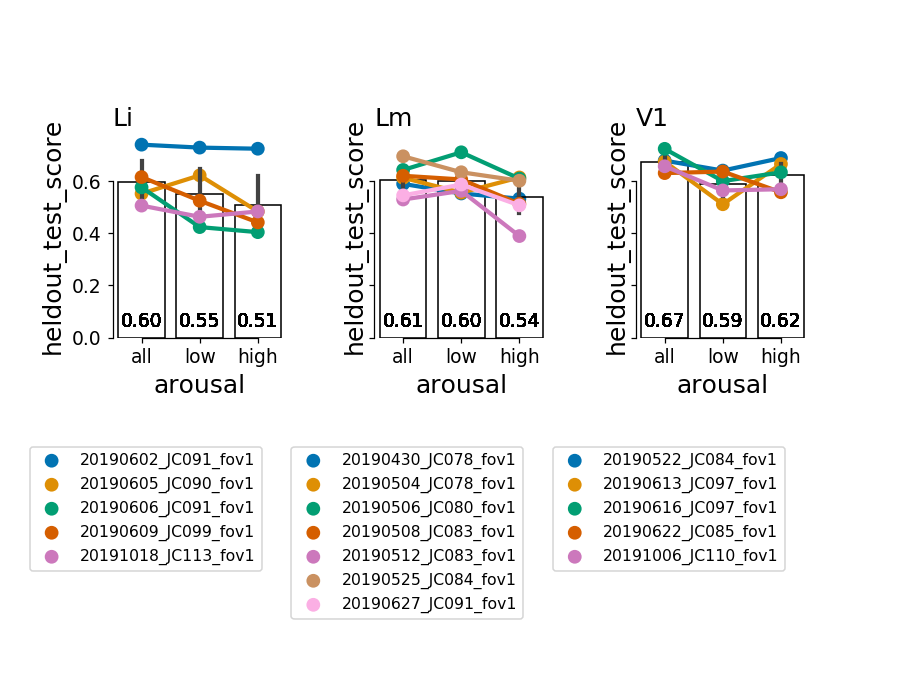

In [123]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']
metric='heldout_test_score'
#metric='heldout_aMI'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
ai=0
fig, axn = pl.subplots(1, 3, figsize=(8,6), dpi=dpi, sharex=True, sharey=True)
for ax, (visual_area, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
#     if ai!=2:
#         ax.legend_.remove()
#     else:
    ax.set_title(visual_area, loc='left', fontsize=16)
    
    ax.legend(bbox_to_anchor=(0.9, -0.5))
    ai+=1
pl.subplots_adjust(wspace=0.5, bottom=0.5, top=0.8)
sns.despine(trim=True)

In [202]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']

<IPython.core.display.Javascript object>


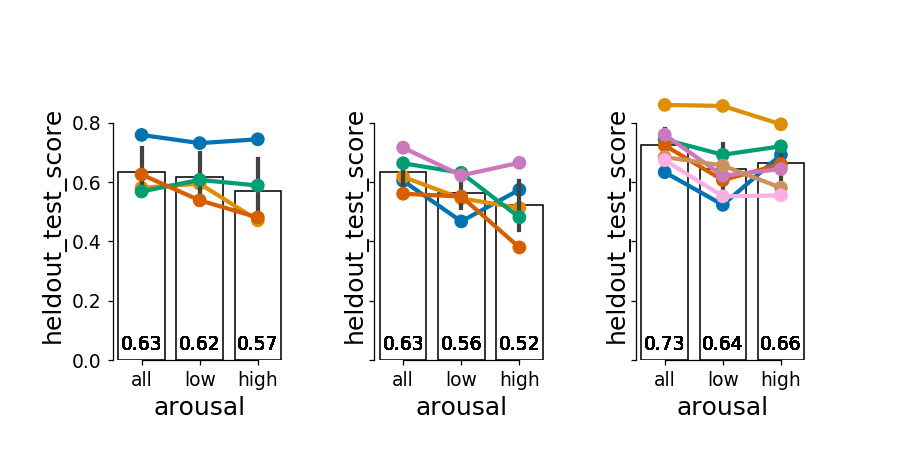

In [203]:
metric='heldout_test_score'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi, sharex=True, sharey=True)
for ax, (arousal, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
    ax.legend_.remove()
pl.subplots_adjust(wspace=0.5, bottom=0.2, top=0.8)
sns.despine(trim=True)

In [101]:
def filter_rois(has_blobs, overlap_thr=0.50):
    visual_areas=['V1', 'Lm', 'Li']
    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    
    for (visual_area, datakey), g in has_blobs[has_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):

        roi_counter = roi_counters[visual_area]
        datakeys[visual_area].append(datakey)

        #ddf.sort_values(by='config')
        roi_list = sorted([s for s in g['cell'].unique()]) #[int(r) for r in ddf.columns if r != 'config']

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    #print("%i datasets fail all thresholds:" % len(nocells), nocells)
    for k, v in global_rois.items():
        print(k, len(v))
        
    return roidf